# Capture des chiffres dans les décalques afin de créér le dataset dimage pour construire le model de reconaissance de chiffre : voir le script captures des rois.ipynb

### Data augmentation pour multiplier plusieur image

In [ ]:
import os
from PIL import Image

def duplicate_images(input_folder, output_folder, target_count=750):
    """
    Duplique chaque image target_count fois sans modification
    """
    # Créer le dossier de sortie s'il n'existe pas
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for i in range(1, 32):
        image_name = f"image{i}"
        
        # Chercher l'image avec différentes extensions possibles
        image_path = None
        for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
            test_path = os.path.join(input_folder, image_name + ext)
            if os.path.exists(test_path):
                image_path = test_path
                break
        
        if image_path is None:
            print(f"⚠️  Image {image_name} non trouvée dans {input_folder}")
            continue
        
        # Créer un sous-dossier pour chaque chiffre
        digit_folder = os.path.join(output_folder, f"digit_{i}")
        os.makedirs(digit_folder, exist_ok=True)
        
        # Charger l'image originale
        try:
            original_image = Image.open(image_path)
            print(f"📷 Traitement de l'image {i} ({original_image.size})")
        except Exception as e:
            print(f"❌ Erreur lors du chargement de {image_name}: {e}")
            continue
        
        # Dupliquer l'image target_count fois
        for j in range(target_count):
            output_path = os.path.join(digit_folder, f"{image_name}_{j+1:04d}.png")
            original_image.save(output_path)
        
        print(f"🎉 Terminé pour le chiffre {i}: {target_count} duplications")

def main():
    input_folder = "dataset"  
    output_folder = "dataset_augmented"  
    target_count = 750  

    print("🚀 Début de la duplication des images")
    print(f"📁 Dossier source: {input_folder}")
    print(f"📁 Dossier destination: {output_folder}")
    print(f"🎯 Objectif: {target_count} duplications par chiffre")
    print("-" * 50)

    if not os.path.exists(input_folder):
        print(f"❌ Le dossier {input_folder} n'existe pas!")
        return

    duplicate_images(input_folder, output_folder, target_count)

    print("-" * 50)
    print("✨ Duplication terminée!")

    # Statistiques finales
    total_images = 0
    for i in range(1, 32):
        digit_folder = os.path.join(output_folder, f"digit_{i}")
        if os.path.exists(digit_folder):
            count = len([f for f in os.listdir(digit_folder) if f.endswith('.png')])
            total_images += count
            print(f"📊 Chiffre {i}: {count} images")

    print(f"📈 Total: {total_images} images générées")


main()


### Entrainement du model 

Found 18600 images belonging to 31 classes.
Found 4650 images belonging to 31 classes.
Epoch 1/6
1163/1163 [==============================] - 329s 280ms/step - loss: 0.4715 - accuracy: 0.8714 - val_loss: 0.2685 - val_accuracy: 0.9222
Epoch 2/6
1163/1163 [==============================] - 219s 188ms/step - loss: 0.0984 - accuracy: 0.9718 - val_loss: 0.0721 - val_accuracy: 0.9815
Epoch 3/6
1163/1163 [==============================] - 213s 183ms/step - loss: 0.1247 - accuracy: 0.9735 - val_loss: 7.8756 - val_accuracy: 0.5178
Epoch 4/6
1163/1163 [==============================] - 218s 187ms/step - loss: 0.0730 - accuracy: 0.9857 - val_loss: 1.0323 - val_accuracy: 0.8877
Epoch 5/6
1163/1163 [==============================] - 220s 189ms/step - loss: 0.0713 - accuracy: 0.9878 - val_loss: 0.0183 - val_accuracy: 0.9970
Epoch 6/6
1163/1163 [==============================] - 217s 186ms/step - loss: 0.0699 - accuracy: 0.9895 - val_loss: 0.0292 - val_accuracy: 0.9955


c:\Master\Semestre 2\PI\Projet\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Modèle sauvegardé sous cnn_digits_model.h5


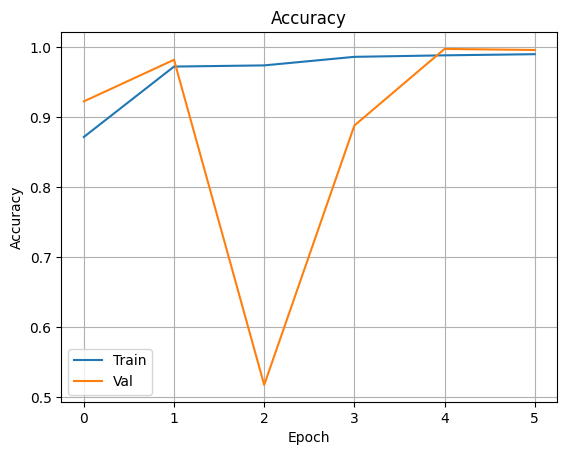

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt

# Réglages
img_height = 64
img_width = 64
batch_size = 16
epochs = 6
dataset_dir = 'dataset_augmented'

# Chargement des données avec augmentation légère
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_data = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    color_mode='rgb',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb',
    shuffle=True
)

# Nombre de classes
num_classes = train_data.num_classes

# Modèle CNN simple
model = Sequential([
    
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),

    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compilation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraînement
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data
)

# Sauvegarde du modèle
model.save('cnn_digits_model.h5')
print("✅ Modèle sauvegardé sous cnn_digits_model.h5")

# Affichage des courbes
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Test du model de lecture de chiffre 

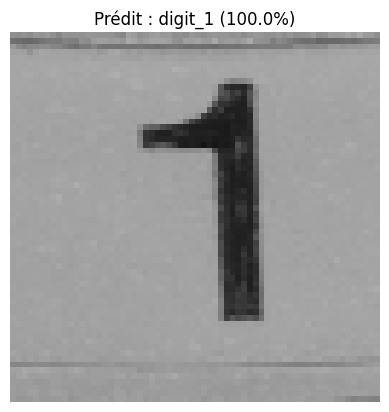

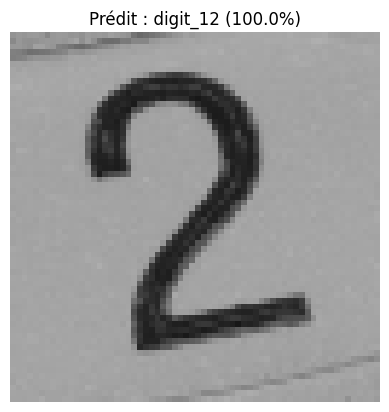

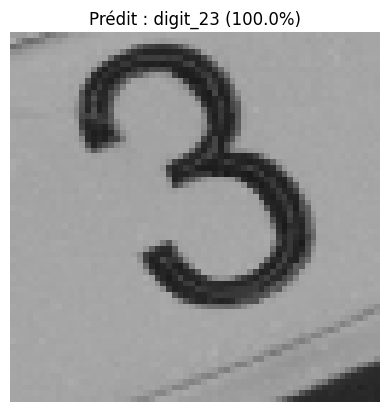

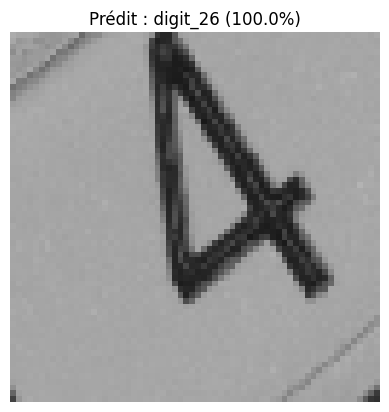

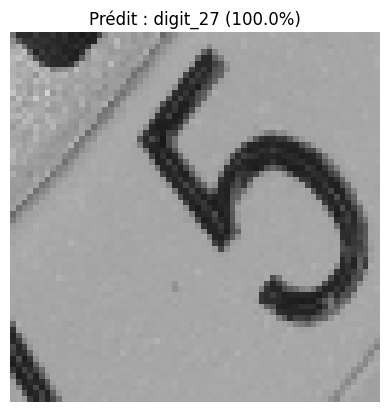

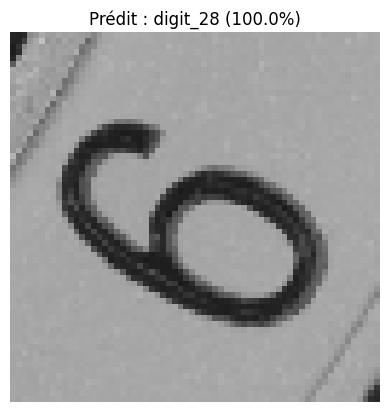

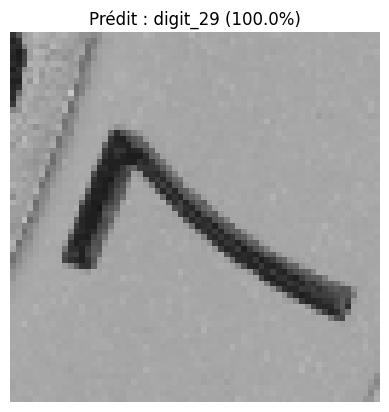

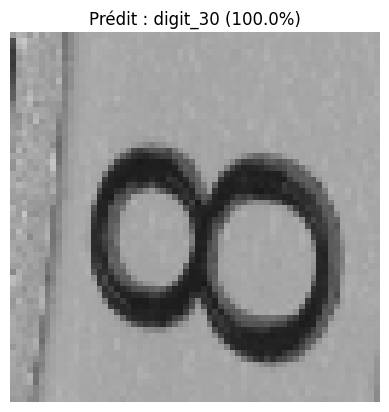

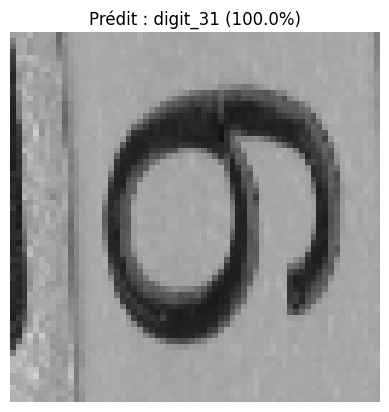

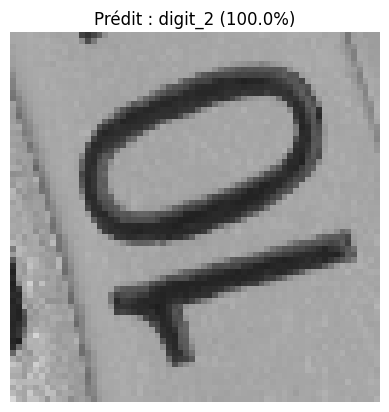

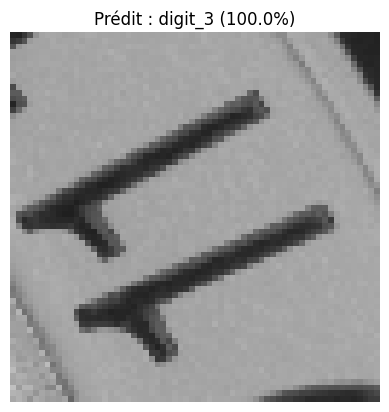

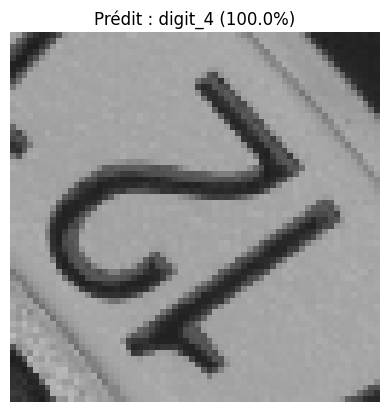

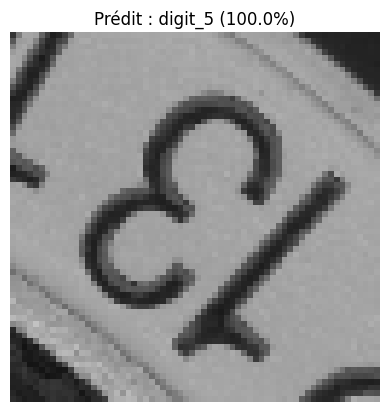

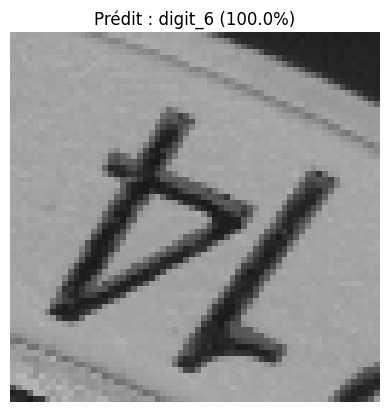

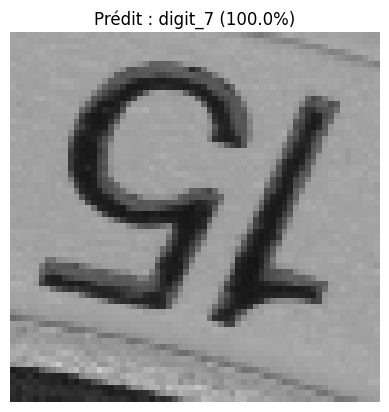

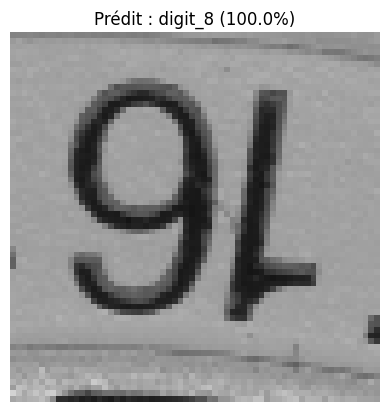

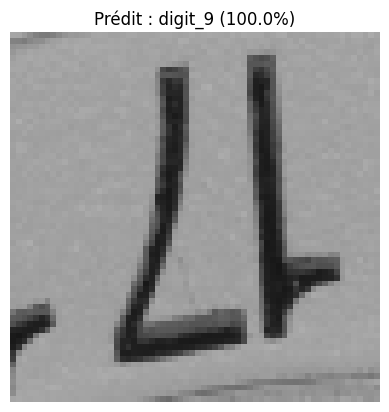

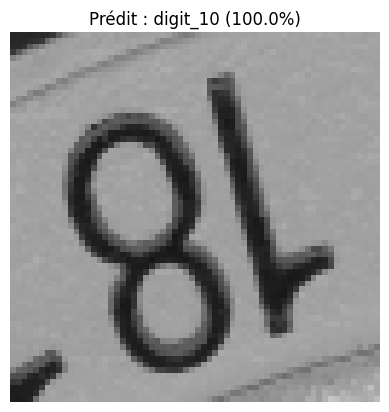

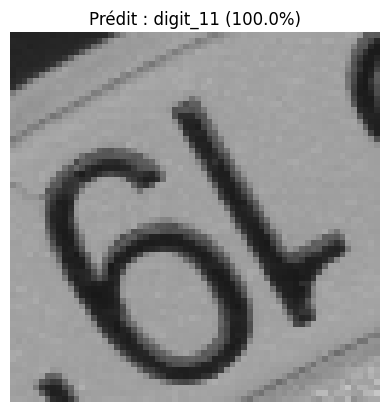

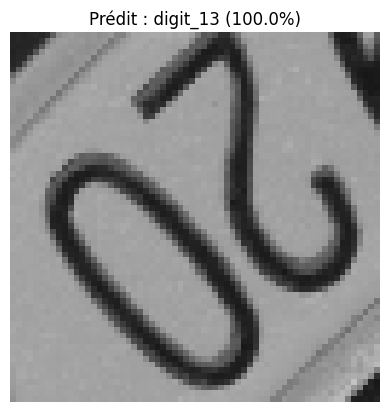

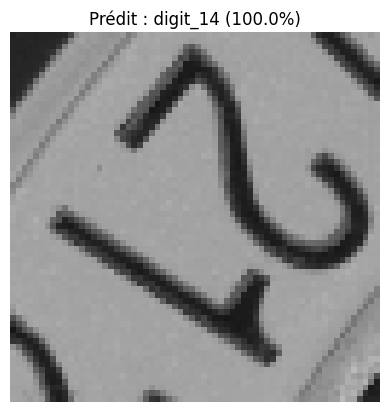

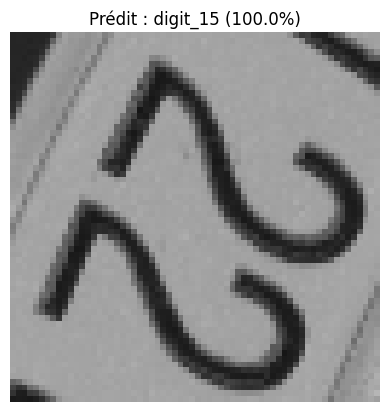

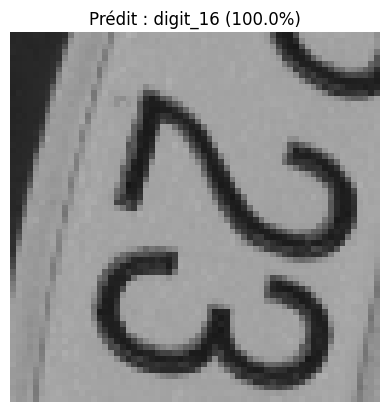

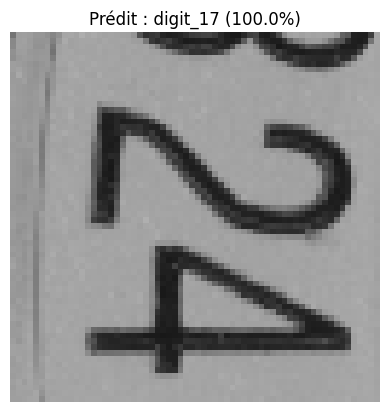

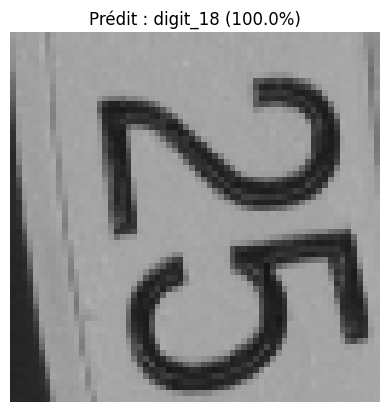

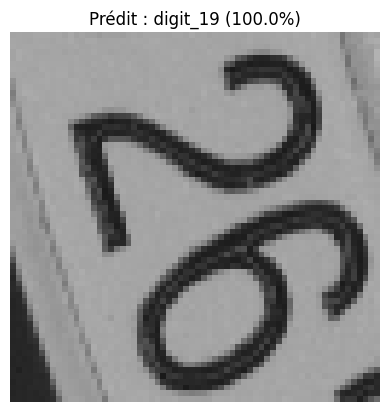

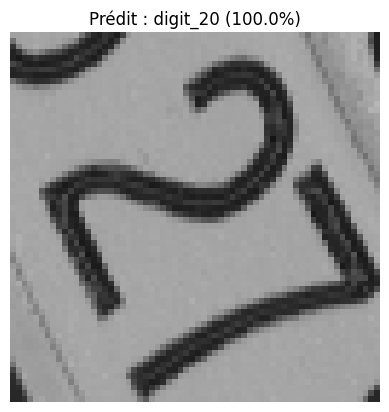

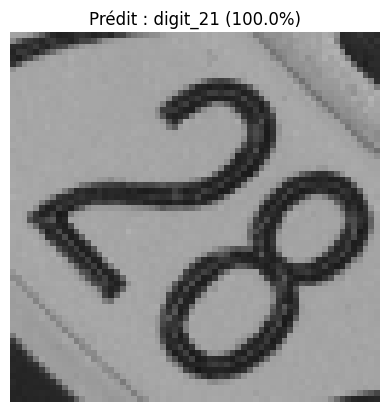

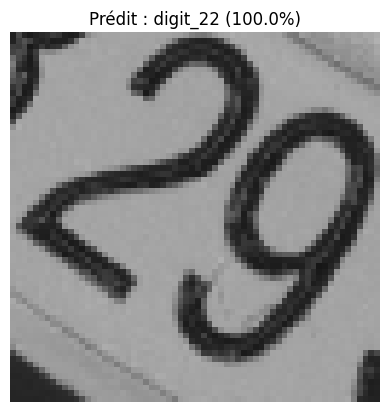

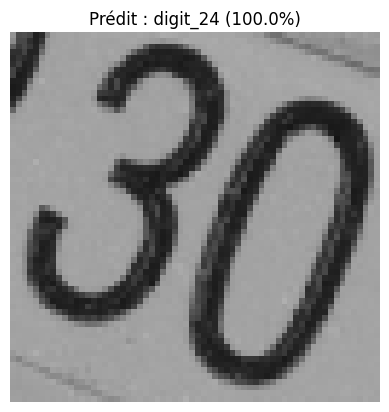

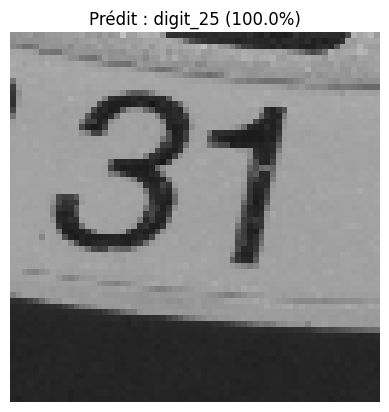


📋 Liste des chiffres prédits :
[1, 12, 23, 26, 27, 28, 29, 30, 31, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25]

📌 Analyse de conformité (chiffres attendus : 1 à 31) :
✅ Conforme : tous les chiffres de 1 à 31 sont présents.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Chargement du modèle
model = load_model("cnn_digits_model.h5")

# Dossier contenant les images à prédire
input_dir = "extracted_rois"

# Lire tous les fichiers image valides
image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]


target_size = (64, 64)

# Liste pour stocker les prédictions
predicted_digits = []

# Boucle sur les images
for img_name in image_files:
    img_path = os.path.join(input_dir, img_name)

    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(prediction[0])
    confidence = np.max(prediction[0]) * 100

    predicted_digits.append(predicted_class + 1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Prédit : digit_{predicted_class + 1} ({confidence:.1f}%)")
    plt.axis("off")
    plt.show()

# Analyse de conformité
print("\n📋 Liste des chiffres prédits :")
print(predicted_digits)

# Vérification conformité : de 1 à 31
expected_digits = set(range(1, 31))
predicted_set = set(predicted_digits)
missing_digits = expected_digits - predicted_set

print("\n📌 Analyse de conformité (chiffres attendus : 1 à 31) :")
if not missing_digits:
    print("✅ Conforme : tous les chiffres de 1 à 31 sont présents.")
else:
    print("❌ Non conforme : il manque les chiffres suivants :", sorted(missing_digits))
